In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.stats import norm
plt.rcParams["figure.figsize"] = (5,4)

In [2]:
res_1 = 'results/dict/'
res_2 = '../temp/results/dict/'
file_name = [res_1 + f for f in os.listdir(res_1)] + [res_2 + f for f in os.listdir(res_2)]

In [3]:
clip = 2.0
folds = 5
lr = 0.5
epsilon = [0.5, 1.0, 3.0, 5.0, 7.0, 9.0]
ns_ = {
    'bank': [21.75, 11.517, 4.3384, 2.83, 2.1743, 1.8079],
    'adult': [3.55, 1.98, 0.982, 0.794, 0.704, 0.648]
}

### Utils

In [4]:
def read_pickel(file):
    with open(file, 'rb') as f:
        res = pickle.load(f)
    return res

In [5]:
def disperate_impact(male_loader, female_loader, global_model, male_model, female_model, num_male, num_female, device = 'cpu'):
    global_model.to(device)
    male_model.to(device)
    female_model.to(device)

    glob_male_out = []
    glob_female_out = []
    male_outputs = []
    female_outputs = []

    global_model.eval()
    male_model.eval()
    female_model.eval()
    with torch.no_grad():

        for bi, d in enumerate(male_loader):
            
            features, _, ismale = d
            # print(ismale) 
            
            features = features.to(device, dtype=torch.float)

            glob_out = global_model(features)
            male_out = male_model(features)

            glob_out = torch.squeeze(glob_out, dim=-1)
            glob_out = glob_out.cpu().detach().numpy()
            glob_male_out.extend(glob_out)

            male_out = torch.squeeze(male_out, dim=-1)
            male_out = male_out.cpu().detach().numpy()
            male_outputs.extend(male_out)

        for bi, d in enumerate(female_loader):
            features, _, ismale = d
            # print(ismale)
            features = features.to(device, dtype=torch.float)

            glob_out = global_model(features)
            female_out = female_model(features)

            glob_out = torch.squeeze(glob_out, dim=-1)
            glob_out = glob_out.cpu().detach().numpy()
            glob_female_out.extend(glob_out)

            female_out = torch.squeeze(female_out, dim=-1)
            female_out = female_out.cpu().detach().numpy()
            female_outputs.extend(female_out)

    male_outputs = np.array(male_outputs)
    glob_male_out = np.array(glob_male_out)
    female_outputs = np.array(female_outputs)
    glob_female_out = np.array(glob_female_out)

    male_norm = np.sum(np.abs(male_outputs - glob_male_out))
    female_norm = np.sum(np.abs(female_outputs - glob_female_out))
    return male_norm / num_male, female_norm / num_female

In [6]:
def get_tilde_sigma(ns, clip, bz1, bz2):
    return ns*clip*np.sqrt(1/(bz1**2) + 1/(bz2**2))

def expected_bound(ns, clip, num_params, lr):
    return 2*lr*clip*np.sqrt(num_params) + lr*num_params*ns*np.sqrt(2)/np.sqrt(np.pi)

def worstcase_bound(ns, num_params, lr, alpha=0.05):
    return 2*lr*clip*np.sqrt(num_params) + lr*ns*np.sqrt(-2*np.log(alpha)*num_params + 2*num_params**2*np.log(2))

In [7]:
def plot_performance(dataset, noise_scale, epsilon):
    performance_fairdp = []
    for ns in noise_scale:
        num_file = 0
        test_acc = 0
        for i, file in enumerate(file_name):
            if (dataset in file) and ('sigma_{}'.format(ns) in file) and ('fairdp_track' in file):
                res = read_pickel(file=file)
                test_acc += res['test_history_acc'][-1]
                num_file += 1
        performance_fairdp.append(test_acc/num_file)
    
    performance_dpsgd = []
    for ns in noise_scale:
        num_file = 0
        test_acc = 0
        for i, file in enumerate(file_name):
            if (dataset in file) and ('sigma_{}'.format(ns) in file) and ('dpsgd' in file):
                res = read_pickel(file=file)
                test_acc += res['test_history_acc'][-1]
                num_file += 1
        performance_dpsgd.append(test_acc/num_file)
    
    performance_func = []
    for eps in epsilon:
        num_file = 0
        test_acc = 0
        for i, file in enumerate(file_name):
            if (dataset in file) and ('submode_func_org_eps_{}'.format(eps) in file):
                res = read_pickel(file=file)
                test_acc += res['test_history_acc'][-1]
                num_file += 1
        performance_func.append(test_acc/num_file)
    
    plt.plot(range(len(epsilon)), np.ones(len(epsilon))*0.8986206896551724, '-s', label = 'no-DP (clean)')
    plt.plot(range(len(epsilon)), performance_dpsgd, '-o', label = 'DPSGD')
    plt.plot(range(len(epsilon)), performance_func, '-o', label = 'Functional')
    plt.plot(range(len(epsilon)), performance_fairdp, '-*', label = 'FairDP (our)')
    plt.ylabel('ACC')
    plt.xlabel(r'$\epsilon$')
    plt.title('{} dataset'.format(dataset))
    plt.xticks(range(len(epsilon)), epsilon)
    plt.legend()

### Read Data

In [8]:
df = pd.read_csv('Data/Bank/formated_bank.csv')
feature_cols = list(df.columns)
feature_cols.remove('y')
feature_cols.remove('z')
feature_cols.remove('label')
feature_cols.remove('is_train')
feature_cols.remove('intercept')
label = 'y'
train_df = df[df['is_train'] == 1].reset_index(drop=True).sample(frac = 1)
test_df = df[df['is_train'] == 0].reset_index(drop=True).sample(frac = 1)
male_df = test_df[test_df['z'] == 1]
female_df = test_df[test_df['z'] == 0]
male_train_df = train_df[train_df['z'] == 1]
female_train_df = train_df[train_df['z'] == 0]
print("Dataset Bank")
print(train_df.shape, test_df.shape, len(feature_cols))
print(len(male_train_df)/len(train_df), len(female_train_df)/len(train_df))

Dataset Bank
(4131, 21) (1450, 21) 16
0.06608569353667393 0.9339143064633261


In [9]:
header = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
label_dict = {
    ' <=50K': '<=50K',
    ' >50K': '>50K',
    ' <=50K.': '<=50K',
    ' >50K.': '>50K'
}
train_df = pd.read_csv('Data/Adult/adult.data', header=None)
test_df = pd.read_csv('Data/Adult/adult.test', skiprows=1, header=None)
all_data = pd.concat([train_df, test_df], axis=0)
all_data.columns = header
def hour_per_week(x):
    if x <= 19:
        return '0'
    elif (x > 19) & (x <= 29):
        return '1'
    elif (x > 29) & (x <= 39):
        return '2'
    elif x > 39:
        return '3'
def age(x):
    if x <= 24:
        return '0'
    elif (x > 24) & (x <= 34):
        return '1'
    elif (x > 34) & (x <= 44):
        return '2'
    elif (x > 44) & (x <= 54):
        return '3'
    elif (x > 54) & (x <= 64):
        return '4'
    else:
        return '5'
def country(x):
    if x == ' United-States':
        return 0
    else:
        return 1
all_data['hours-per-week'] = all_data['hours-per-week'].map(lambda x: hour_per_week(x))
all_data['age'] = all_data['age'].map(lambda x: age(x))
all_data['native-country'] = all_data['native-country'].map(lambda x: country(x))
all_data = all_data.drop(
    ['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss'],
    axis=1)
temp = pd.get_dummies(all_data['age'], prefix='age')
all_data = pd.concat([all_data, temp], axis=1)
all_data = all_data.drop('age', axis=1)
temp = pd.get_dummies(all_data['workclass'], prefix='workclass')
all_data = pd.concat([all_data, temp], axis=1)
all_data = all_data.drop('workclass', axis=1)
temp = pd.get_dummies(all_data['education'], prefix='education')
all_data = pd.concat([all_data, temp], axis=1)
all_data = all_data.drop('education', axis=1)
temp = pd.get_dummies(all_data['race'], prefix='race')
all_data = pd.concat([all_data, temp], axis=1)
all_data = all_data.drop('race', axis=1)
temp = pd.get_dummies(all_data['hours-per-week'], prefix='hour')
all_data = pd.concat([all_data, temp], axis=1)
all_data = all_data.drop('hours-per-week', axis=1)
all_data['income'] = all_data['income'].map(label_dict)
lb = LabelEncoder()
all_data['sex'] = lb.fit_transform(all_data['sex'].values)
lb = LabelEncoder()
all_data['income'] = lb.fit_transform(all_data['income'].values)
train_df = all_data[:train_df.shape[0]].reset_index(drop=True)
test_df = all_data[train_df.shape[0]:].reset_index(drop=True)

feature_cols = list(train_df.columns)
feature_cols.remove('income')
feature_cols.remove('sex')
label = 'income'
z = 'sex'
male_df = train_df[train_df['sex'] == 1].copy()
female_df = train_df[train_df['sex'] == 0].copy()
print('Dataset Adult')
print(train_df.shape, test_df.shape, len(feature_cols))
print(len(male_df)/len(train_df), len(female_df)/len(train_df))

Dataset Adult
(32561, 43) (16281, 43) 41
0.6692054912318418 0.33079450876815825


### Plot performance

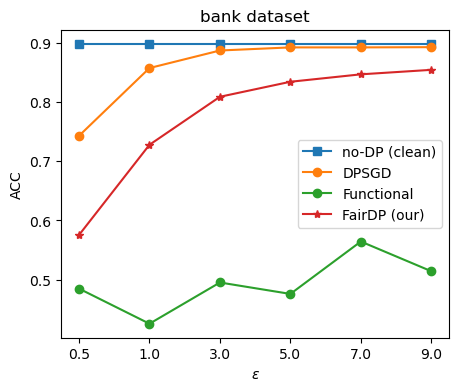

In [10]:
plot_performance(dataset='bank', noise_scale = ns_['bank'], epsilon=epsilon)

### Plot Fairness

In [11]:
file_path = 'results/dict/'
file_name = os.listdir(file_path)
noise_scale = ns_['bank']
disp_func = []
for eps in epsilon:
    num_file = 0
    test_acc = 0
    for i, file in enumerate(file_name):
        if ('bank_' in file) and ('eps_{}'.format(eps) in file) and ('submode_func' in file):
            with open('{}{}'.format(file_path,file), 'rb') as f:
                res = pickle.load(f)
                # print(res.keys())
                test_acc += res['best_disp_imp']
                num_file += 1
    disp_func.append(test_acc/num_file)
    
disp_dpsgd = []
for ns in noise_scale:
    num_file = 0
    test_acc = 0
    for i, file in enumerate(file_name):
        if ('bank_' in file) and ('sigma_{}'.format(ns) in file) and ('fairdp_fold' in file):
            # print(file)
            with open('{}{}'.format(file_path,file), 'rb') as f:
                res = pickle.load(f)
                # print(res.keys())
                test_acc += res['disp_imp'][-1]
                num_file += 1
    disp_dpsgd.append(test_acc/num_file)

disp_clean = []
ns = 183.45
num_file = 0
test_acc = 0
for i, file in enumerate(file_name):
    if ('bank_' in file) and ('sigma_{}'.format(ns) in file) and ('fair_fold' in file):
        with open('{}{}'.format(file_path,file), 'rb') as f:
            res = pickle.load(f)
            # print(res.keys())
            # print(res['test_history_acc'])
            test_acc += res['disp_imp'][-1]
            num_file += 1
disp_clean.append(test_acc/num_file)

file_path_ = '../temp/results/dict/'
file_name_ = os.listdir(file_path_)
disp_func = []
for eps in epsilon:
    num_file = 0
    test_acc = 0
    for i, file in enumerate(file_name_):
        if ('bank_' in file) and ('submode_func_eps_{}'.format(eps) in file):
            # print(file)
            with open('{}{}'.format(file_path_,file), 'rb') as f:
                res = pickle.load(f)
                # print(res.keys())
                test_acc += res['disp_imp'][-1]
                num_file += 1
    print(num_file)
    disp_func.append(test_acc/num_file)

6
5
5
5
5
5


In [12]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class NormLogit(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NormLogit, self).__init__()
        self.layer_1 = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        norm = torch.norm(x, dim=-1, keepdim=True).repeat(1, x.size(dim=-1)) + 1e-16
        x = torch.div(x, norm)
        x = self.layer_1(x)
        out = torch.nn.functional.sigmoid(x)
        return out


class Data(Dataset):
    def __init__(self, X, y, ismale):
        self.ismale = torch.from_numpy(ismale)
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index], self.ismale[index]

    def __len__(self):
        return self.len
    
df = pd.read_csv('Data/Bank/formated_bank.csv')
# df['bias'] = np.ones(df.shape[0])
feature_cols = list(df.columns)
feature_cols.remove('y')
feature_cols.remove('z')
feature_cols.remove('label')
feature_cols.remove('is_train')
feature_cols.remove('intercept')
label = 'y'
train_df = df[df['is_train'] == 1].reset_index(drop=True).sample(frac = 1)
test_df = df[df['is_train'] == 0].reset_index(drop=True).sample(frac = 1)
male_df = test_df[test_df['z'] == 1]
female_df = test_df[test_df['z'] == 0]
    
    
male_dataset = Data(
    X=male_df[feature_cols].values,
    y=male_df['y'].values,
    ismale=male_df['z'].values
)

female_dataset = Data(
    X=female_df[feature_cols].values,
    y=female_df['y'].values,
    ismale=female_df['z'].values
)

male_loader = DataLoader(
    male_dataset,
    batch_size=32,
    num_workers=4,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
)

female_loader = DataLoader(
    female_dataset,
    batch_size=32,
    num_workers=4,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
)

model_male = NormLogit(16, 2, 1)
model_female = NormLogit(16, 2, 1)
global_model = NormLogit(16, 2,1)
global_model_ = NormLogit(16, 2,1)

model_path = 'results/models/'
model_name = os.listdir(model_path)
ns_date = {}
for ns in noise_scale:
    date = []
    for i, file in enumerate(model_name):
        if ('bank_' in file) and ('sigma_{}'.format(ns) in file) and ('fairdp_track' in file):
            date.append('_'.join(file.split('_')[-2:]))
    ns_date[ns] = set(date)

disp_imp_fairdp = []
# disp_imp_dpsgd = []
for ns in noise_scale:
    date = ns_date[ns]
    disp = 0
    num_file = 0
    for d in date:
        model_female.load_state_dict(torch.load('results/models/female_bank_fairdp_track_fold_0_sigma_{}_C_2.0_epochs_1250_{}'.format(ns, d), map_location='cpu'))
        model_male.load_state_dict(torch.load('results/models/male_bank_fairdp_track_fold_0_sigma_{}_C_2.0_epochs_1250_{}'.format(ns, d), map_location='cpu'))
        global_model.load_state_dict(torch.load('results/models/bank_fairdp_track_fold_0_sigma_{}_C_2.0_epochs_1250_{}'.format(ns, d), map_location='cpu'))
        male_norm, female_norm = disperate_impact(male_loader=male_loader, female_loader=female_loader, global_model = global_model, male_model = model_male, female_model = model_female, num_male=117, num_female=1333)
        disp += max(male_norm, female_norm)
        num_file += 1
    # print(disp/num_file)
    disp_imp_fairdp.append(disp/num_file)

/Users/khangtran/anaconda3/envs/torch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/khangtran/anaconda3/envs/torch/lib/python3.7/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [13]:
def bellet_bound(num_params, ns, alpha):
    return 4*num_params*ns**2*np.log(2/alpha)

In [14]:
len(feature_cols)

16

In [15]:
clip = 2.0
tbound = []
wbound = []
bbound = []
for i, ns in enumerate(noise_scale):
    tilde_sigma = get_tilde_sigma(ns=ns, clip=clip, bz1=245, bz2=17)
    bbound.append(bellet_bound(num_params = len(feature_cols), ns=ns, alpha=0.95))
    tbound.append(expected_bound(ns=tilde_sigma, clip=clip, num_params=len(feature_cols), lr = 0.0104))
    wbound.append(worstcase_bound(ns=tilde_sigma, num_params=len(feature_cols), lr = 0.0104))

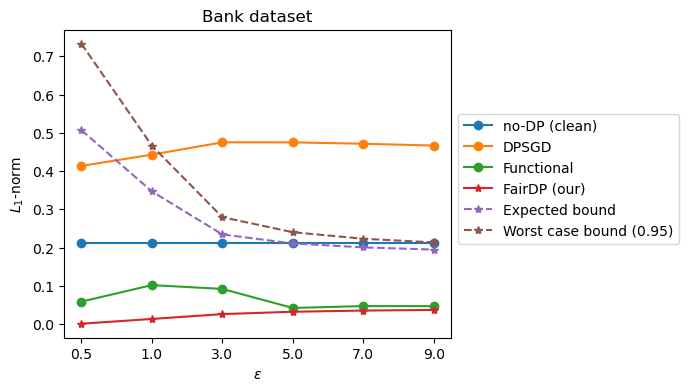

In [16]:
plt.plot(range(len(epsilon)), np.ones(len(epsilon))*0.21288373080166903, '-o', label = 'no-DP (clean)')
plt.plot(range(len(epsilon)), disp_dpsgd, '-o', label = 'DPSGD')
plt.plot(range(len(epsilon)), disp_func, '-o', label = 'Functional')
plt.plot(range(len(epsilon)), disp_imp_fairdp, '-*', label = 'FairDP (our)')
plt.plot(range(len(epsilon)), tbound, '--*', label = 'Expected bound')
plt.plot(range(len(epsilon)), wbound, '--*', label = 'Worst case bound (0.95)')
# plt.fill_between(range(len(epsilon)), np.ones(len(epsilon))*0.21288373080166903 - np.array(bbound), np.ones(len(epsilon))*0.21288373080166903 + np.array(bbound), alpha=0.2, label='bellet box')
plt.ylabel(r'$L_1$-norm')
plt.xlabel(r'$\epsilon$')
plt.title('Bank dataset')
plt.xticks(range(len(epsilon)), epsilon)
plt.legend(bbox_to_anchor=(1, 0.75))

### Adult

In [14]:
for f in file_name:
    if 'adult' in f:
        print(f)

../temp/results/dict/adult_func_fold_0_submode_func_eps_3.0_epochs_2000_412023_1026.pkl
../temp/results/dict/adult_fairdp_track_fold_0_sigma_0.794_C_2.0_epochs_500_412023_14031.pkl
../temp/results/dict/adult_func_fold_0_submode_func_eps_1.0_epochs_2000_412023_05713.pkl
../temp/results/dict/adult_fairdp_track_fold_0_sigma_0.704_C_2.0_epochs_500_412023_15026.pkl
../temp/results/dict/adult_fairdp_fold_0_sigma_0.794_C_2.0_epochs_500_412023_0407.pkl
../temp/results/dict/adult_fairdp_track_fold_0_sigma_0.704_C_2.0_epochs_500_412023_2139.pkl
../temp/results/dict/adult_fairdp_fold_0_sigma_3.55_C_2.0_epochs_500_412023_1341.pkl
../temp/results/dict/adult_fairdp_track_fold_0_sigma_0.648_C_2.0_epochs_500_412023_05332.pkl
../temp/results/dict/adult_func_fold_0_submode_func_eps_0.5_epochs_2000_412023_0524.pkl
../temp/results/dict/adult_fair_fold_0_sigma_35.0_C_2.0_epochs_500_412023_0354.pkl
../temp/results/dict/adult_fairdp_fold_0_sigma_0.982_C_2.0_epochs_500_412023_11411.pkl
../temp/results/dict/ad

In [24]:
def plot_performance(dataset, noise_scale, epsilon):
    performance_fairdp = []
    for ns in noise_scale:
        num_file = 0
        test_acc = 0
        for i, file in enumerate(file_name):
            if (dataset in file) and ('sigma_{}'.format(ns) in file) and ('fairdp_track' in file):
                res = read_pickel(file=file)
                test_acc += res['test_history_acc'][-1]
                num_file += 1
        performance_fairdp.append(test_acc/num_file)
    
    performance_dpsgd = []
    for ns in noise_scale:
        num_file = 0
        test_acc = 0
        for i, file in enumerate(file_name):
            if (dataset in file) and ('sigma_{}'.format(ns) in file) and ('fairdp_fold' in file):
                res = read_pickel(file=file)
                test_acc += res['test_history_acc'][-1]
                num_file += 1
        performance_dpsgd.append(test_acc/num_file)
    
    performance_func = []
    for eps in epsilon:
        num_file = 0
        test_acc = 0
        for i, file in enumerate(file_name):
            if (dataset in file) and ('submode_func_eps_{}'.format(eps) in file):
                res = read_pickel(file=file)
                test_acc += res['best_test']
                num_file += 1
        performance_func.append(test_acc/num_file)
    
    plt.plot(range(len(epsilon)), np.ones(len(epsilon))*0.8006264971439101, '-s', label = 'no-DP (clean)')
    plt.plot(range(len(epsilon)), performance_dpsgd, '-o', label = 'DPSGD')
    plt.plot(range(len(epsilon)), performance_func, '-o', label = 'Functional')
    plt.plot(range(len(epsilon)), performance_fairdp, '-*', label = 'FairDP (our)')
    plt.ylabel('ACC')
    plt.xlabel(r'$\epsilon$')
    plt.title('Adult dataset'.format(dataset))
    plt.xticks(range(len(epsilon)), epsilon)
    plt.legend()

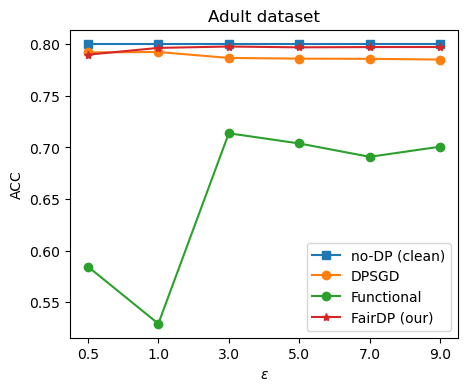

In [25]:
plot_performance(dataset='adult', noise_scale=ns_['adult'], epsilon=epsilon)

In [17]:
header = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
label_dict = {
    ' <=50K': '<=50K',
    ' >50K': '>50K',
    ' <=50K.': '<=50K',
    ' >50K.': '>50K'
}
train_df = pd.read_csv('Data/Adult/adult.data', header=None)
test_df = pd.read_csv('Data/Adult/adult.test', skiprows=1, header=None)
all_data = pd.concat([train_df, test_df], axis=0)
all_data.columns = header
def hour_per_week(x):
    if x <= 19:
        return '0'
    elif (x > 19) & (x <= 29):
        return '1'
    elif (x > 29) & (x <= 39):
        return '2'
    elif x > 39:
        return '3'
def age(x):
    if x <= 24:
        return '0'
    elif (x > 24) & (x <= 34):
        return '1'
    elif (x > 34) & (x <= 44):
        return '2'
    elif (x > 44) & (x <= 54):
        return '3'
    elif (x > 54) & (x <= 64):
        return '4'
    else:
        return '5'
def country(x):
    if x == ' United-States':
        return 0
    else:
        return 1
all_data['hours-per-week'] = all_data['hours-per-week'].map(lambda x: hour_per_week(x))
all_data['age'] = all_data['age'].map(lambda x: age(x))
all_data['native-country'] = all_data['native-country'].map(lambda x: country(x))
all_data = all_data.drop(
    ['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss'],
    axis=1)
temp = pd.get_dummies(all_data['age'], prefix='age')
all_data = pd.concat([all_data, temp], axis=1)
all_data = all_data.drop('age', axis=1)
temp = pd.get_dummies(all_data['workclass'], prefix='workclass')
all_data = pd.concat([all_data, temp], axis=1)
all_data = all_data.drop('workclass', axis=1)
temp = pd.get_dummies(all_data['education'], prefix='education')
all_data = pd.concat([all_data, temp], axis=1)
all_data = all_data.drop('education', axis=1)
temp = pd.get_dummies(all_data['race'], prefix='race')
all_data = pd.concat([all_data, temp], axis=1)
all_data = all_data.drop('race', axis=1)
temp = pd.get_dummies(all_data['hours-per-week'], prefix='hour')
all_data = pd.concat([all_data, temp], axis=1)
all_data = all_data.drop('hours-per-week', axis=1)
all_data['income'] = all_data['income'].map(label_dict)
lb = LabelEncoder()
all_data['sex'] = lb.fit_transform(all_data['sex'].values)
lb = LabelEncoder()
all_data['income'] = lb.fit_transform(all_data['income'].values)
train_df = all_data[:train_df.shape[0]].reset_index(drop=True)
test_df = all_data[train_df.shape[0]:].reset_index(drop=True)

feature_cols = list(train_df.columns)
feature_cols.remove('income')
feature_cols.remove('sex')
label = 'income'
z = 'sex'
male_df = train_df[train_df['sex'] == 1].copy()
female_df = train_df[train_df['sex'] == 0].copy()
print('Dataset Adult')
print(train_df.shape, test_df.shape, len(feature_cols))
print(len(male_df)/len(train_df), len(female_df)/len(train_df))

Dataset Adult
(32561, 43) (16281, 43) 41
0.6692054912318418 0.33079450876815825


In [18]:
train_df.head()

,sex,native-country,income,age_0,age_1,age_2,age_3,age_4,age_5,workclass_ ?,...,education_ Some-college,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,hour_0,hour_1,hour_2,hour_3
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [19]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(train_df[feature_cols].values, train_df[label].values)
clf.score(test_df[feature_cols].values, test_df[label].values)

/Users/khangtran/anaconda3/envs/torch/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.8006264971439101

In [38]:
file_path = '../temp/results/dict/'
file_name = os.listdir(file_path)
noise_scale = ns_['adult']
disp_func = []
for eps in epsilon:
    num_file = 0
    test_acc = 0
    for i, file in enumerate(file_name):
        if ('adult_' in file) and ('eps_{}'.format(eps) in file) and ('submode_func' in file):
            with open('{}{}'.format(file_path,file), 'rb') as f:
                res = pickle.load(f)
                # print(res.keys())
                test_acc += res['best_disp_imp']
                num_file += 1
    disp_func.append(test_acc/num_file)
    
disp_dpsgd = []
for ns in noise_scale:
    num_file = 0
    test_acc = 0
    for i, file in enumerate(file_name):
        if ('adult_' in file) and ('sigma_{}'.format(ns) in file) and ('fairdp_fold' in file):
            # print(file)
            with open('{}{}'.format(file_path,file), 'rb') as f:
                res = pickle.load(f)
                # print(res.keys())
                test_acc += res['disp_imp'][-1]
                num_file += 1
    disp_dpsgd.append(test_acc/num_file)

disp_clean = []
num_file = 0
test_acc = 0
for i, file in enumerate(file_name):
    if ('adult_' in file) and ('fair_fold' in file):
        with open('{}{}'.format(file_path,file), 'rb') as f:
            res = pickle.load(f)
            # print(res.keys())
            # print(res['test_history_acc'])
            test_acc += res['disp_imp'][-1]
            num_file += 1
disp_clean.append(test_acc/num_file)

file_path_ = '../temp/results/dict/'
file_name_ = os.listdir(file_path_)
disp_func = []
for eps in epsilon:
    num_file = 0
    test_acc = 0
    for i, file in enumerate(file_name_):
        if ('adult_' in file) and ('submode_func_eps_{}'.format(eps) in file):
            # print(file)
            with open('{}{}'.format(file_path_,file), 'rb') as f:
                res = pickle.load(f)
                # print(res.keys())
                test_acc += res['disp_imp'][-1]
                num_file += 1
    print(num_file)
    disp_func.append(test_acc/num_file)

5
5
5
5
5
5


In [41]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class NormLogit(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NormLogit, self).__init__()
        self.layer_1 = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        norm = torch.norm(x, dim=-1, keepdim=True).repeat(1, x.size(dim=-1)) + 1e-16
        x = torch.div(x, norm)
        x = self.layer_1(x)
        out = torch.nn.functional.sigmoid(x)
        return out


class Data(Dataset):
    def __init__(self, X, y, ismale):
        self.ismale = torch.from_numpy(ismale)
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index], self.ismale[index]

    def __len__(self):
        return self.len
    
# df = pd.read_csv('Data/Bank/formated_bank.csv')
# # df['bias'] = np.ones(df.shape[0])
# feature_cols = list(df.columns)
# feature_cols.remove('y')
# feature_cols.remove('z')
# feature_cols.remove('label')
# feature_cols.remove('is_train')
# feature_cols.remove('intercept')
# label = 'y'
# train_df = df[df['is_train'] == 1].reset_index(drop=True).sample(frac = 1)
# test_df = df[df['is_train'] == 0].reset_index(drop=True).sample(frac = 1)
male_df = test_df[test_df['sex'] == 1]
female_df = test_df[test_df['sex'] == 0]
print(len(male_df), len(female_df))
    
    
male_dataset = Data(
    X=male_df[feature_cols].values,
    y=male_df['income'].values,
    ismale=male_df['sex'].values
)

female_dataset = Data(
    X=female_df[feature_cols].values,
    y=female_df['income'].values,
    ismale=female_df['sex'].values
)

male_loader = DataLoader(
    male_dataset,
    batch_size=32,
    num_workers=4,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
)

female_loader = DataLoader(
    female_dataset,
    batch_size=32,
    num_workers=4,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
)

model_male = NormLogit(len(feature_cols), 2, 1)
model_female = NormLogit(len(feature_cols), 2, 1)
global_model = NormLogit(len(feature_cols), 2,1)

model_path = '../temp/results/models/'
model_name = os.listdir(model_path)
ns_date = {}
for ns in noise_scale:
    date = []
    for i, file in enumerate(model_name):
        if ('adult_' in file) and ('sigma_{}'.format(ns) in file) and ('fairdp_track' in file):
            date.append('_'.join(file.split('_')[-2:]))
    ns_date[ns] = set(date)

disp_imp_fairdp = []
# disp_imp_dpsgd = []
for ns in noise_scale:
    date = ns_date[ns]
    disp = 0
    num_file = 0
    for d in date:
        model_female.load_state_dict(torch.load('../temp/results/models/female_adult_fairdp_track_fold_0_sigma_{}_C_2.0_epochs_500_{}'.format(ns, d), map_location='cpu'))
        model_male.load_state_dict(torch.load('../temp/results/models/male_adult_fairdp_track_fold_0_sigma_{}_C_2.0_epochs_500_{}'.format(ns, d), map_location='cpu'))
        global_model.load_state_dict(torch.load('../temp/results/models/adult_fairdp_track_fold_0_sigma_{}_C_2.0_epochs_500_{}'.format(ns, d), map_location='cpu'))
        male_norm, female_norm = disperate_impact(male_loader=male_loader, female_loader=female_loader, global_model = global_model, male_model = model_male, female_model = model_female, num_male=117, num_female=1333)
        disp += max(male_norm, female_norm)
        num_file += 1
    # print(disp/num_file)
    disp_imp_fairdp.append(disp/num_file)

10860 5421


/Users/khangtran/anaconda3/envs/torch/lib/python3.7/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [29]:
disp_clean

[0.07572409955193014]

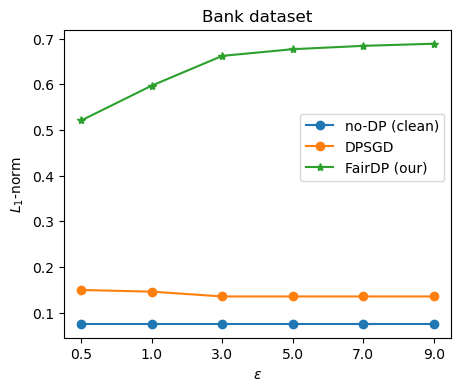

In [42]:
plt.plot(range(len(epsilon)), np.ones(len(epsilon))*0.07572409955193014, '-o', label = 'no-DP (clean)')
plt.plot(range(len(epsilon)), disp_dpsgd, '-o', label = 'DPSGD')
# plt.plot(range(len(epsilon)), disp_func, '-o', label = 'Functional')
plt.plot(range(len(epsilon)), disp_imp_fairdp, '-*', label = 'FairDP (our)')
# plt.plot(range(len(epsilon)), tbound, '--*', label = 'Expected bound')
# plt.plot(range(len(epsilon)), wbound, '--*', label = 'Worst case bound (0.95)')
# plt.fill_between(range(len(epsilon)), np.ones(len(epsilon))*0.21288373080166903 - np.array(bbound), np.ones(len(epsilon))*0.21288373080166903 + np.array(bbound), alpha=0.2, label='bellet box')
plt.ylabel(r'$L_1$-norm')
plt.xlabel(r'$\epsilon$')
plt.title('Bank dataset')
plt.xticks(range(len(epsilon)), epsilon)
plt.legend(bbox_to_anchor=(1, 0.75))